In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [62]:
def get_cutoff_indices(df: pd.DataFrame, n_features: int) -> list:
    """
    Get the indices of the cutoffs for each feature in the dataframe
    """
    df_len = len(df)
    cutoff_indices = []

    
    for i in range(df_len-n_features):
        first_index = i
        last_index = i + n_features-1
        next_index = i + n_features
        cutoff_indices.append((first_index, last_index, next_index))

    return cutoff_indices


In [94]:
df_total = pd.read_parquet('../data/transformed/transformed_filtered_yellow_tripdata_2023-10.parquet')

In [95]:
df = df_total[df_total['PULocationID'] == 43]

In [96]:
cutoff_indices = get_cutoff_indices(df, 24)

In [97]:
cutoff_indices[-1]

(719, 742, 743)

In [98]:
n_features = 24

In [99]:
df

,pickup_hour,rides,PULocationID
9672,2023-10-01 00:00:00,24.0,43
9673,2023-10-01 01:00:00,14.0,43
9674,2023-10-01 02:00:00,6.0,43
9675,2023-10-01 03:00:00,0.0,43
9676,2023-10-01 04:00:00,3.0,43
...,...,...,...
10411,2023-10-31 19:00:00,51.0,43
10412,2023-10-31 20:00:00,88.0,43
10413,2023-10-31 21:00:00,49.0,43
10414,2023-10-31 22:00:00,37.0,43


In [100]:
# create feature matrix
feature_matrix = np.zeros(shape=(len(cutoff_indices), n_features))

feature_matrix[0] = df['rides'].iloc[0:24].values

In [101]:
feature_matrix.shape

(720, 24)

In [102]:
n_features

24

In [103]:
feature_matrix[0]

feature_matrix[1] = df['rides'].iloc[1:25].values

In [104]:
feature_matrix[1]

array([ 14.,   6.,   0.,   3.,   3.,  14.,   8.,  26.,  51.,  86., 110.,
       148., 136., 143., 153., 216., 137., 104.,  63.,  35.,  30.,  29.,
        10.,   1.])

In [105]:
cutoff_indices[-1]

(719, 742, 743)

In [71]:
feature_matrix[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [107]:
# create cutoff indices
cutoff_indices = get_cutoff_indices(df, n_features=24)

# create feature matrix
feature_matrix = np.zeros(shape=(len(cutoff_indices), n_features))

# loop through the cutoff indices and create the feature matrix
for i, (first_index,last_index, next_index) in tqdm(enumerate(cutoff_indices)):
    feature_matrix[i] = df['rides'].iloc[first_index:last_index+1].values




720it [00:00, 58568.30it/s]


In [108]:
import numpy as np
from tqdm import tqdm

def create_feature_matrix_and_target(df, cutoff_indices):
    """
    Creates a feature matrix and a target vector from a DataFrame using sliding window indices.
    
    Args:
    - df: A pandas DataFrame containing the time series data (e.g., column 'rides').
    - cutoff_indices: A list of tuples (first_index, last_index, next_index) generated by the `get_cutoff_indices()` function.
    - n_features: The number of previous time steps to use as features (sliding window size).
    
    Returns:
    - feature_matrix: A NumPy array where each row contains a sliding window values.
    - target_vector: A NumPy array containing the target value (the value at `next_index` for each window).
    """
    
    # Generate the feature matrix using list comprehension
    feature_matrix = np.array([
        df['rides'].iloc[first_index:last_index+1].values 
        for first_index, last_index, _ in tqdm(cutoff_indices)
    ])
    
    # Generate the target vector using list comprehension
    target_vector = np.array([
        df['rides'].iloc[next_index] for _, _, next_index in tqdm(cutoff_indices)
    ])
    
    return feature_matrix, target_vector

In [109]:
# Create both feature matrix and target vector
feature_matrix, target_vector = create_feature_matrix_and_target(df, cutoff_indices)

100%|██████████| 720/720 [00:00<00:00, 191205.45it/s]


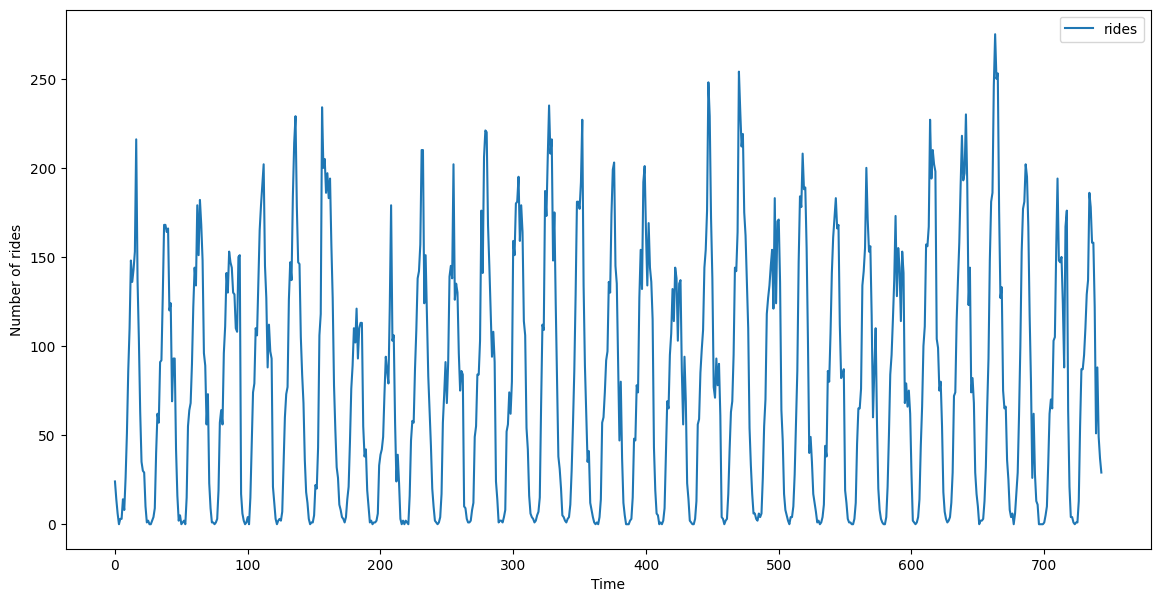

In [111]:
# plot df rides

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(df['rides'].values, label='rides')
plt.xlabel('Time')
plt.ylabel('Number of rides')
plt.legend()
plt.show()

In [133]:

def process_feature_target_by_PULocationID(file_path, n_features):
    """
    Process a parquet file, segmenting the data by PULocationID, and apply sliding window transformation
    for each PULocationID. Outputs a single DataFrame with PULocationID, features, and target.
    
    Args:
    - file_path: Path to the parquet file containing data.
    - n_features: The number of previous time steps to use as features (sliding window size).
    
    Returns:
    - A single DataFrame with PULocationID, features (feature_0 to feature_{n_features-1}), and target.
    """
    # Load the parquet file
    df = pd.read_parquet(file_path)

    # Get unique PULocationIDs
    unique_pulocation_ids = df['PULocationID'].unique()
    
    # List to store the results
    rows = []

    # Process each PULocationID separately
    for pulocation_id in tqdm(unique_pulocation_ids):
        # Filter the dataframe for this specific PULocationID
        df_location = df[df['PULocationID'] == pulocation_id].sort_values('pickup_hour')

        # Generate cutoff indices for the time series
        cutoff_indices = get_cutoff_indices(df_location, n_features=n_features)
        
        if len(cutoff_indices) == 0:
            # Skip if there's not enough data to generate the feature matrix
            continue
        
        # Create feature matrix and target vector
        feature_matrix, target_vector = create_feature_matrix_and_target(df_location, cutoff_indices)
        
        # Append the PULocationID, features, and target to the result list
        for i in range(feature_matrix.shape[0]):
            row = [pulocation_id] + list(feature_matrix[i]) + [target_vector[i]]
            rows.append(row)

    # Create a DataFrame with the collected rows
    columns = ['PULocationID'] + [f'feature_{i}' for i in range(n_features)] + ['target']
    final_df = pd.DataFrame(rows, columns=columns)
    
    return final_df

In [134]:
pulocationid_results = process_feature_target_by_PULocationID('../data/transformed/transformed_filtered_yellow_tripdata_2023-10.parquet', n_features=24)

100%|██████████| 256/256 [00:06<00:00, 39.80it/s]


In [136]:
pulocationid_results[pulocationid_results['PULocationID'] == 43]

,PULocationID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,target
9360,43,24.0,14.0,6.0,0.0,3.0,3.0,14.0,8.0,26.0,...,153.0,216.0,137.0,104.0,63.0,35.0,30.0,29.0,10.0,1.0
9361,43,14.0,6.0,0.0,3.0,3.0,14.0,8.0,26.0,51.0,...,216.0,137.0,104.0,63.0,35.0,30.0,29.0,10.0,1.0,2.0
9362,43,6.0,0.0,3.0,3.0,14.0,8.0,26.0,51.0,86.0,...,137.0,104.0,63.0,35.0,30.0,29.0,10.0,1.0,2.0,0.0
9363,43,0.0,3.0,3.0,14.0,8.0,26.0,51.0,86.0,110.0,...,104.0,63.0,35.0,30.0,29.0,10.0,1.0,2.0,0.0,0.0
9364,43,3.0,3.0,14.0,8.0,26.0,51.0,86.0,110.0,148.0,...,63.0,35.0,30.0,29.0,10.0,1.0,2.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,43,88.0,167.0,176.0,64.0,21.0,4.0,4.0,1.0,0.0,...,95.0,110.0,129.0,137.0,186.0,178.0,158.0,158.0,122.0,51.0
10076,43,167.0,176.0,64.0,21.0,4.0,4.0,1.0,0.0,1.0,...,110.0,129.0,137.0,186.0,178.0,158.0,158.0,122.0,51.0,88.0
10077,43,176.0,64.0,21.0,4.0,4.0,1.0,0.0,1.0,1.0,...,129.0,137.0,186.0,178.0,158.0,158.0,122.0,51.0,88.0,49.0
10078,43,64.0,21.0,4.0,4.0,1.0,0.0,1.0,1.0,13.0,...,137.0,186.0,178.0,158.0,158.0,122.0,51.0,88.0,49.0,37.0


In [152]:
import os
import pandas as pd

def process_all_transformed_files(input_dir='../data/transformed', output_dir='../data/time_series', n_features=24):
    """
    Process all files in the 'data/transformed' folder that follow the naming pattern
    'transformed_filtered_{type}_{year}-{month}.parquet' and save them to 'data/time_series' 
    with the name 'ts_{type}_{year}-{month}.parquet'.
    
    Args:
    - input_dir: Directory where the transformed parquet files are located.
    - output_dir: Directory where the time series parquet files will be saved.
    - n_features: Number of previous time steps to use as features (default is 24).
    
    Returns:
    - None: The function saves the processed files in the output directory.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate over all parquet files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.parquet') and filename.startswith('transformed_filtered_'):
            try:
                # Remove the prefix and suffix to get the core file name
                file_core = filename.replace('transformed_filtered_', '').replace('.parquet', '')

                # Use the last underscore to separate the type from the year-month
                data_type, year_month = file_core.rsplit('_', 1)
                
                # Extract year and month from the year_month string
                year, month = year_month.split('-')
                # Create the new filename following the pattern ts_{type}_{year}-{month}.parquet
                output_filename = f'ts_{data_type}_{year}-{month}.parquet'
                output_path = os.path.join(output_dir, output_filename)

                # Skip the file if it already exists
                if os.path.exists(output_path):
                    print(f"{output_filename} already exists. Skipping.")
                    continue

                # Full path to the current input file
                input_path = os.path.join(input_dir, filename)

                # Process the file to get the time series data for each PULocationID
                print(f"Processing {filename}...")
                final_df = process_feature_target_by_PULocationID(input_path, n_features)

                # Save the processed DataFrame as a parquet file
                final_df.to_parquet(output_path)
                print(f"Saved {output_filename} to {output_dir}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")


In [151]:
# Execute the process in all 'data/transformed'
process_all_transformed_files(input_dir='../data/transformed', output_dir='../data/time_series', n_features=24)


yellow_tripdata_2022-03
yellow_tripdata 2022-03
Processing transformed_filtered_yellow_tripdata_2022-03.parquet...


100%|██████████| 257/257 [00:06<00:00, 40.14it/s]


Saved ts_yellow_tripdata_2022-03.parquet to ../data/time_series
yellow_tripdata_2021-01
yellow_tripdata 2021-01
Processing transformed_filtered_yellow_tripdata_2021-01.parquet...


100%|██████████| 258/258 [00:06<00:00, 41.11it/s]


Saved ts_yellow_tripdata_2021-01.parquet to ../data/time_series
green_tripdata_2021-01
green_tripdata 2021-01
Processing transformed_filtered_green_tripdata_2021-01.parquet...


100%|██████████| 251/251 [00:06<00:00, 40.22it/s]


Saved ts_green_tripdata_2021-01.parquet to ../data/time_series
yellow_tripdata_2023-12
yellow_tripdata 2023-12
Processing transformed_filtered_yellow_tripdata_2023-12.parquet...


100%|██████████| 720/720 [00:00<00:00, 197961.25it/s]
